# 猫狗大战（Dogs vs Cats）

## 项目介绍

使用要迁移学习的模型，将数据集中的bottleneck特征提取出来，方便后续训练新模型。
 

## 1. 导入数据集

将下载的数据集压缩包解压到指定到文件夹中。

In [1]:
import zipfile
import os
import shutil

# Unzip all zip file to the path.
def UnzipFile(filename, datapath):
    # Check filename
    if filename.strip() == "":
        print("filename should not be null string!")
        return False

    # Check datapath
    if datapath.strip() == "":
        print("datapath should not be null string!")
        return False
    
    # Check file exist
    if not os.path.exists(filename):
        print("{} not found!".format(filename))
        return False

    # Check filename's extension
    if os.path.splitext(filename)[1] != '.zip':
        print("{} should be with '*.zip' ext!".format(filename))
        return False

    # Unzip the file
    file_zip = zipfile.ZipFile(filename, 'r')
    for file in file_zip.namelist():
        file_zip.extract(file, datapath)
        sub_filename = os.path.join(datapath, file)

        if os.path.splitext(sub_filename)[1] != '.zip':
            continue

        UnzipFile(sub_filename, datapath)

    file_zip.close()
    os.remove(filename)
    print("unzip {} successfully!".format(filename))

    return True  

# Format the data files for trainning models.
def FormatDatas(datapath):
    train_list = os.listdir(datapath + "/train")
    train_dog = list(filter(lambda x:x[:3] == "dog", train_list))
    os.makedirs(datapath + "/train/dog")
    for file in train_dog:
        shutil.move(datapath + "/train/" + file, datapath + "/train/dog/" + file)

    train_cat = list(filter(lambda x:x[:3] == "cat", train_list))
    os.makedirs(datapath + "/train/cat")
    for file in train_cat:
        shutil.move(datapath + "/train/" + file, datapath + "/train/cat/" + file)

if not os.path.exists("datas/"):
    UnzipFile("train.zip", "datas/")
    UnzipFile("test.zip", "datas/") 
#     FormatDatas("datas/")
else:
    print("datas is ok!")

datas is ok!


读取datas目录下的数据集，并分为train和test两类。

In [2]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

data = load_files('datas')

files = np.array(data['filenames'])
targets = np.array(data['target'])
target_names = np.array(data['target_names'])

train_files = [files[idx] for idx in range(len(files)) if targets[idx] == np.argwhere(target_names == 'train')]
test_files = [files[idx] for idx in range(len(files)) if targets[idx] == np.argwhere(target_names == 'test')]

def getFileName(elem):
    _,file = os.path.split(elem)
    name,_ = os.path.splitext(file)
    return int(name)
test_files.sort(key=getFileName)

print("There are {} train images.".format(len(train_files)))
print("There are {} test images.".format(len(test_files)))

Using TensorFlow backend.


There are 25000 train images.
There are 12500 test images.


可视化训练数据集中前12张图片。

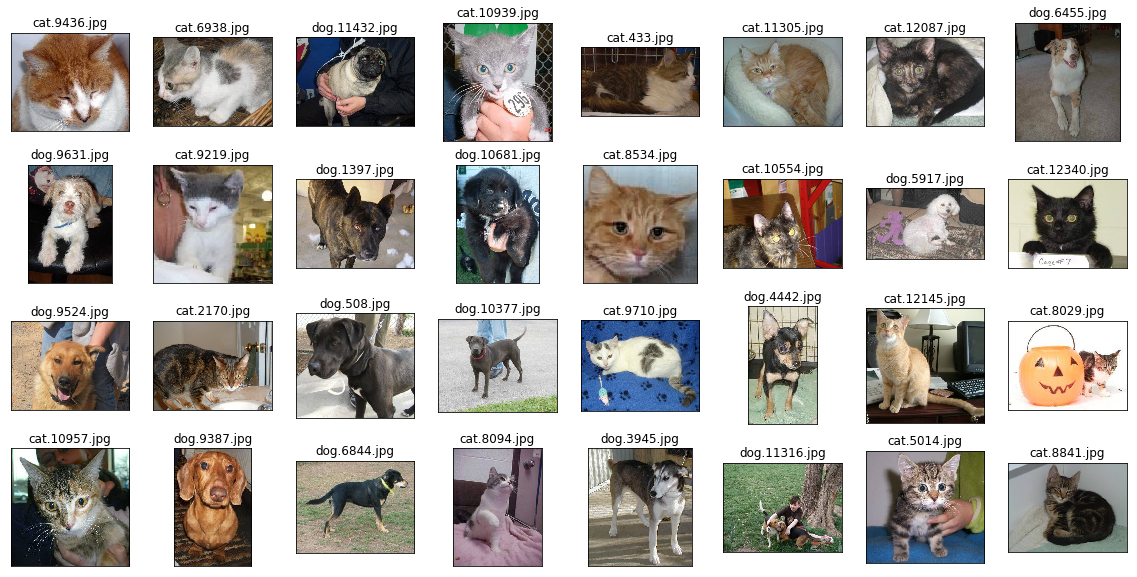

In [3]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

def visualize_img(img_path, ax):
    img = cv2.imread(img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
fig = plt.figure(figsize=(20, 10))
for i in range(32):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)
    _,file = os.path.split(train_files[i])
    ax.set_title("{}".format(file))

<a id="step1"></a>
## 2. 数据分析

### 2.1 分析数据分布

分析图片的分辨率的散点分布。

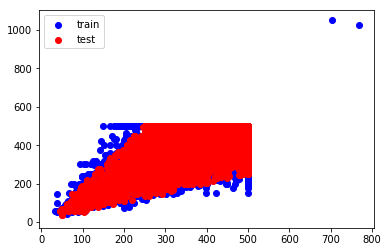

In [14]:
import cv2
import matplotlib.pyplot as plt

def img_shapes(files):
    X = []
    Y = []
    for file in files:
        img = cv2.imread(file)
        X.append(img.shape[0])
        Y.append(img.shape[1])
    return X,Y

# 提取训练集图片分辨率信息
train_X, train_Y = img_shapes(train_files)
test_X, test_Y = img_shapes(test_files)

# 散点图可视化图片的分辨率分布情况
fig = plt.figure()
ax = fig.add_subplot(111)
p1 = ax.scatter(train_X,train_Y, color='b')
p2 = ax.scatter(test_X,test_Y, color='r')
ax.legend((p1, p2), ('train', 'test'), loc=2)
plt.show()

可视化异常数据

There are 2 images with invalid shape!


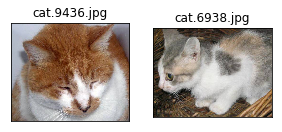

In [15]:
# 筛选分辨率异常的数据
ids = []
for i in range(len(train_files)):
    if train_X[i] > 600 or train_Y[i] > 600:
        ids.append(i)
print("There are {} images with invalid shape!".format(len(ids)))

# 可视化分辨率异常的数据
fig = plt.figure(figsize=(20, 10))
for i in range(len(ids)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[i], ax)
    _,file = os.path.split(train_files[i])
    ax.set_title("{}".format(file))

### 2.2 数据处理

根据文件名，读取图片文件中的数据

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # 用PIL加载RGB图像为PIL.Image.Image类型
    img = image.load_img(img_path, target_size=(224, 224))
    # 将PIL.Image.Image类型转化为格式为(224, 224, 3)的3维张量
    x = image.img_to_array(img)
    # 将3维张量转化为格式为(1, 224, 224, 3)的4维张量并返回
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# 加载图片资源
train_tensors = paths_to_tensor(train_files)
test_tensors = paths_to_tensor(test_files)

100%|██████████| 12500/12500 [00:35<00:00, 352.33it/s]


### 2.3 数据清洗

由于我们无法保证数据的正确性，需要通过数据清洗进行排查。

In [6]:
# ImageNet中所有狗的分类
dogs = [
 'n02085620','n02085782','n02085936','n02086079'
,'n02086240','n02086646','n02086910','n02087046'
,'n02087394','n02088094','n02088238','n02088364'
,'n02088466','n02088632','n02089078','n02089867'
,'n02089973','n02090379','n02090622','n02090721'
,'n02091032','n02091134','n02091244','n02091467'
,'n02091635','n02091831','n02092002','n02092339'
,'n02093256','n02093428','n02093647','n02093754'
,'n02093859','n02093991','n02094114','n02094258'
,'n02094433','n02095314','n02095570','n02095889'
,'n02096051','n02096177','n02096294','n02096437'
,'n02096585','n02097047','n02097130','n02097209'
,'n02097298','n02097474','n02097658','n02098105'
,'n02098286','n02098413','n02099267','n02099429'
,'n02099601','n02099712','n02099849','n02100236'
,'n02100583','n02100735','n02100877','n02101006'
,'n02101388','n02101556','n02102040','n02102177'
,'n02102318','n02102480','n02102973','n02104029'
,'n02104365','n02105056','n02105162','n02105251'
,'n02105412','n02105505','n02105641','n02105855'
,'n02106030','n02106166','n02106382','n02106550'
,'n02106662','n02107142','n02107312','n02107574'
,'n02107683','n02107908','n02108000','n02108089'
,'n02108422','n02108551','n02108915','n02109047'
,'n02109525','n02109961','n02110063','n02110185'
,'n02110341','n02110627','n02110806','n02110958'
,'n02111129','n02111277','n02111500','n02111889'
,'n02112018','n02112137','n02112350','n02112706'
,'n02113023','n02113186','n02113624','n02113712'
,'n02113799','n02113978']

# ImageNet中所有猫的分类
cats=[
'n02123045','n02123159','n02123394','n02123597'
,'n02124075','n02125311','n02127052']

print("There are {} dog types in ImageNet!".format(len(dogs)))
print("There are {} cat types in ImageNet!".format(len(cats)))

There are 118 dog types in ImageNet!
There are 7 cat types in ImageNet!


使用ImageNet数据集预训练的Resnet50来预测训练集数据。

In [7]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions

# 使用经过imagenet训练的无全连接层ResNet50模型
preprocess_model = ResNet50(weights='imagenet')

# 使用imagenet预测train数据集的分类
pred_targets = decode_predictions(preprocess_model.predict(preprocess_input(train_tensors), verbose=1), top=40)

25000/25000 [==============================] - 318s   


根据预测结果，从训练集中筛选出非猫非狗的数据，并清理掉。

Find 55 invalid train images!


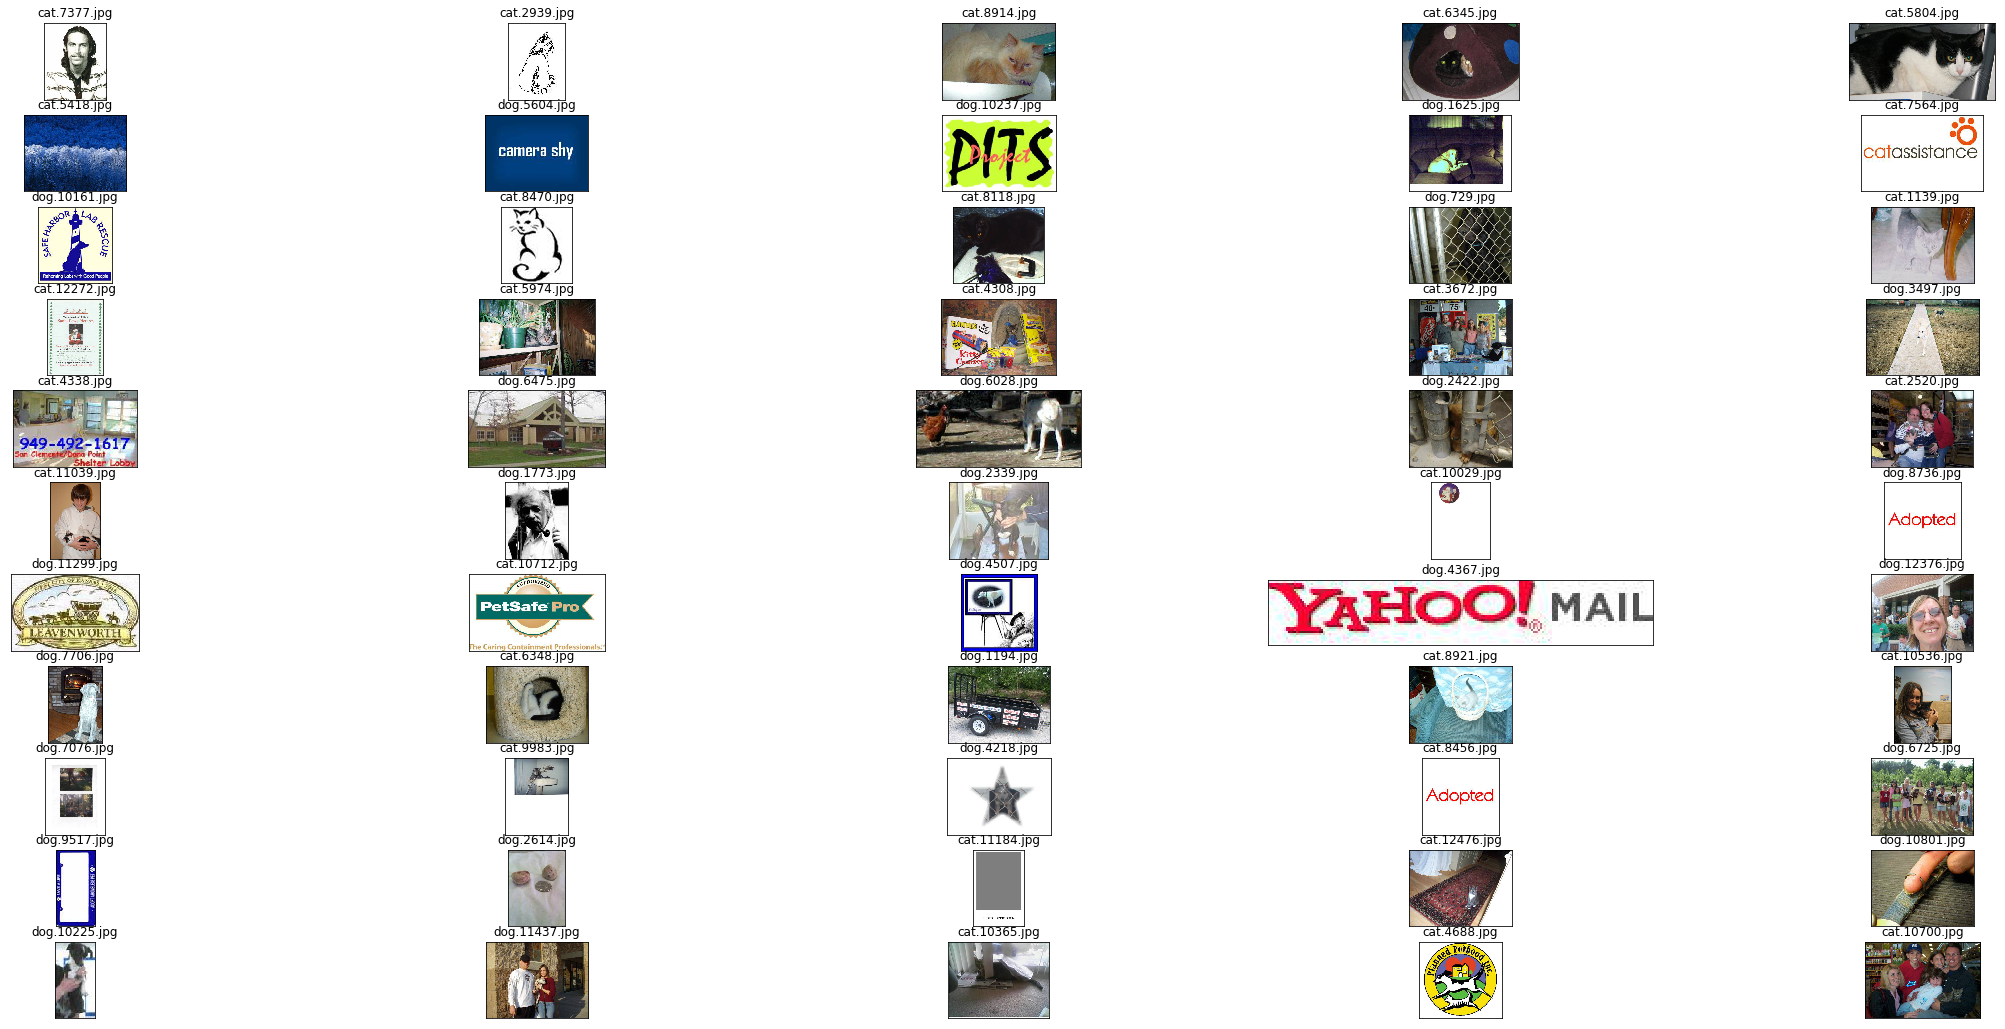

In [8]:
# 从训练集中筛选非猫非狗的数据
ids = []
for i in range(len(pred_targets)):
    for pred in pred_targets[i]:
        if pred[0] in dogs or pred[0] in cats:
            ids.append(i)
            break

error_ids = []
for i in range(len(pred_targets)):
    if i not in ids:
        error_ids.append(i)

# 可视化所有非猫非狗的训练集数据
fig = plt.figure(figsize=(40, 20))
for i in range(len(error_ids)):
    ax = fig.add_subplot(len(error_ids)/5 + 1, 5, i + 1, xticks=[], yticks=[])
    visualize_img(train_files[error_ids[i]], ax)
    _,file = os.path.split(train_files[error_ids[i]])
    ax.set_title("{}".format(file))
    
# 从训练集中删除非猫非狗的数据
temp_files = []
for i in range(len(train_files)):
    if i not in error_ids:
        temp_files.append(train_files[i])
train_files = temp_files

train_tensors = np.delete(train_tensors, error_ids, axis = 0)
print("Find {} invalid train images!".format(len(error_ids)))

### 2.4 提取数据特征

通过查看训练数据集，发现数据集的标注信息是定义在文件名的，从文件名中提取对应的数据特征，如下表：

|文件|标注（cat=0.0,dog=1.0）|
|-|-|
|datas/train/cat.6938.jpg  |0.0|
|datas/train/dog.11432.jpg |1.0|
|datas/train/cat.433.jpg   |0.0|
|datas/train/cat.11305.jpg |0.0|


In [9]:
data_labels = ("cat", "dog")

train_targets = []
for file in train_files:
    for idx in range(len(data_labels)):
        if data_labels[idx] in file:
            train_targets.append(float(idx))

print("The first 5 train file:\n{}\n".format(train_files[0:5]))
print("The first 5 train targets:\n{}\n".format(train_targets[0:5]))

The first 5 train file:
['datas/train/cat.9436.jpg', 'datas/train/cat.6938.jpg', 'datas/train/dog.11432.jpg', 'datas/train/cat.10939.jpg', 'datas/train/cat.433.jpg']

The first 5 train targets:
[0.0, 0.0, 1.0, 0.0, 0.0]



### 2.5 验证集划分

从sklearn.model_selection中导入train_test_split
将train_files和train_targets作为train_test_split的输入变量
设置test_size为0.2，划分出20%的验证集，80%的数据留作新的训练集。
设置random_state随机种子，以确保每一次运行都可以得到相同划分的结果。（随机种子固定，生成的随机序列就是确定的）

In [10]:
from sklearn.model_selection import train_test_split

X_train , X_valid , y_train, y_valid = train_test_split(train_tensors, train_targets, test_size=0.2, random_state=100)

print("Splited train set num: {}".format(len(X_train)))
print("Splited valid set num: {}".format(len(X_valid)))

Splited train set num: 19956
Splited valid set num: 4989


<a id="step2"></a>
## 3. 迁移学习


### 3.1 迁移无全连接层的模型

为了提高模型的训练速度和质量，这里使用迁移学习。

In [11]:
from keras.applications.resnet50 import ResNet50

# 使用经过imagenet训练的无全连接层ResNet50模型
resnet_model = ResNet50(include_top=False, weights='imagenet')
resnet_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, None, None, 64 256                                          
___________________________________________________________________________________________

### 3.2 提取数据集的特征数据

使用迁移的模型分别提取无全连接层的训练集、验证集和测试集的数据特征。

In [12]:
from keras.applications.resnet50 import preprocess_input

# 提取训练集特征
train_input = preprocess_input(X_train)
train_feature = resnet_model.predict(train_input, verbose=1)
print(train_feature.shape)

# 提取验证集特征
valid_input = preprocess_input(X_valid)
valid_feature = resnet_model.predict(valid_input, verbose=1)
print(valid_feature.shape)

# 提取测试集特征
test_input = preprocess_input(test_tensors)
test_feature = resnet_model.predict(test_input, verbose=1)
print(test_feature.shape)

19956/19956 [==============================] - 256s   
(19956, 1, 1, 2048)
4989/4989 [==============================] - 64s    
(4989, 1, 1, 2048)
12500/12500 [==============================] - 159s   
(12500, 1, 1, 2048)


### 3.3 保存特征数据

将上述提取的特征数据保存到文件中。

In [13]:
# 将特征数据保存到bottlenecks
np.savez('bottlenecks_resnet50.npz', 
         X_train=train_feature, y_train=y_train, 
         X_valid=valid_feature, y_valid=y_valid, 
         X_test=test_feature)